In [2]:
FILE_PATH = '../data/ehresp_2014.xlsx'

# Import libraries
import pandas as pd

# Load the ehresp_2014 DataFrame
ehresp_2014 = pd.read_excel(FILE_PATH)

from enum import Enum
class FEATURE_SELECTION_OPTIONS(Enum):
    K_BEST = 'k_best',
    NONE = 'none'

def do_the_stuff(feature_selection_option):
    from enum import Enum
    class COLUMN_TYPES(Enum):
        NUMERICAL = 'numerical',
        CATEGORICAL = 'categorical'

    numerical_columns = ['ertpreat', \
                         'ertseat', \
                         'euexfreq', \
                         'eufastfdfrq']

    categorical_columns = ['eeincome1', \
                           'erhhch', \
                           'erincome', \
                           'erspemch', \
                           'eudietsoda', \
                           'eudrink', \
                           'eueat', \
                           'euexercise', \
                           'eufastfd', \
                           'euffyday', \
                           'eufdsit', \
                           'eusnap', \
                           'eugenhth', \
                           'eugroshp', \
                           'euinclvl', \
                           'euincome2', \
                           'eumeat', \
                           'eumilk', \
                           'euprpmel', \
                           'eusoda', \
                           'eustores', \
                           'eustreason', \
                           'eutherm', \
                           'euwic']

    target_column = 'erbmi'
    
    def drop_records_with_negagive_values_in_column(dataset, col):
        return dataset.loc[dataset[col] >= 0]

    def split_data(dataset):
        import numpy as np
        length = dataset.shape[0]
        train_index_stop = int(length * 0.7)
        permutation = np.random.RandomState(0).permutation(length)

        # Take just the values up to the train_index_stop
        train_permutation = permutation[:train_index_stop]
        # Take the values after the train_index_stop
        test_permutation = permutation[train_index_stop:]

        # Create the training and testing data
        dataset_train = dataset[train_permutation]
        dataset_test = dataset[test_permutation]

        return [dataset_train, dataset_test]

    def prepare_categorical_columns(dataset, columns):
        import pandas as pd
        from sklearn.preprocessing import LabelEncoder

        # Extract columns from dataset; convert to array
        dataset = dataset[columns].values

        # Apply LabelEncoder to multiple columns: https://stackoverflow.com/a/31939145
        dataset = pd.DataFrame(dataset).apply(LabelEncoder().fit_transform).values

        # OHE for multiple columns using pd.get_dummies: https://stackoverflow.com/a/44601764
        # Another get_dummies example: http://queirozf.com/entries/one-hot-encoding-a-feature-on-a-pandas-dataframe-an-example
        # OHE vs. get_dummies: https://medium.com/@guaisang/handling-categorical-features-get-dummies-onehotencoder-and-multicollinearity-f9d473a40417
        dataset_df = pd.DataFrame(dataset, columns=columns)
        # Keep only the columns we want, and drop the extraneous dummy column
        dataset_dummies = pd.get_dummies(dataset_df,
                                         columns=columns,
                                         drop_first=True)
        dataset = dataset_dummies.values

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]

    def prepare_numerical_columns(dataset, columns):
        # Extract columns from dataset; convert to array
        dataset = dataset[columns].values

        # Split dataset
        X_train, X_test = split_data(dataset)

        # Scale values
        from sklearn.preprocessing import StandardScaler
        sc_X = StandardScaler()
        X_train = sc_X.fit_transform(X_train)
        X_test = sc_X.transform(X_test)

        return [X_train, X_test]

    # Define a function to return BMI class
    def get_bmi_class(bmi):
        if bmi < 18.5:
            return 'Underweight'
        elif bmi >= 18.5 and  bmi < 25:
            return 'Normal'
        elif bmi >= 25 and bmi < 30:
            return 'Overweight'
        elif bmi >= 30:
            return 'Obese'
        else:
            return 'Unknown'

    def prepare_target_column(dataset, column, return_column_type):
        import numpy as np
        import pandas as pd
        dataset = dataset[column].values

        if (return_column_type == COLUMN_TYPES.CATEGORICAL):
            dataset = np.asarray(pd.Series(get_bmi_class(bmi) for bmi in dataset))

        # Split dataset
        dataset_train, dataset_test = split_data(dataset)

        return [dataset_train, dataset_test]


    def prepare_data(dataset,
                     categorical_columns,
                     numerical_columns,
                     target_column,
                     target_column_return_type):
        print('\nBegin prepare_data')
        import pandas as pd
        
        dataset = drop_records_with_negagive_values_in_column(dataset, target_column)
        
        X_categorical_train, \
        X_categorical_test = prepare_categorical_columns(dataset, categorical_columns)

        X_numerical_train, \
        X_numerical_test = \
        prepare_numerical_columns(dataset, numerical_columns)

        X_train = pd.DataFrame(X_numerical_train) \
        .merge(pd.DataFrame(X_categorical_train),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_train shape:', X_train.shape)

        X_test = pd.DataFrame(X_numerical_test) \
        .merge(pd.DataFrame(X_categorical_test),
               how='outer',
               left_index=True,
               right_index=True) \
        .values
        print('X_test shape:', X_test.shape)

        y_train, \
        y_test = \
        prepare_target_column(dataset, target_column, target_column_return_type)

        print('y_train shape:', y_train.shape)
        print('y_test shape:', y_test.shape)

        print('End prepare_data()\n')
        return [X_train, X_test, y_train, y_test]

    X_train, X_test, \
    y_train, y_test = \
    prepare_data(dataset = ehresp_2014,
                 categorical_columns = categorical_columns,
                 numerical_columns = numerical_columns,
                 target_column = target_column,
                 target_column_return_type = COLUMN_TYPES.CATEGORICAL)

    if(feature_selection_option == FEATURE_SELECTION_OPTIONS.K_BEST):
        def select_k_best_categorical_features(X_train,
                                               y_train,
                                               X_test,
                                               first_categorical_column_index,
                                               k_best,
                                               score_function):
            print('\nBegin select_k_best_categorical_features()')
            from sklearn.feature_selection import SelectKBest
            import numpy as np

            print('Before selection: X_train.shape', X_train.shape)

            select_k_best = SelectKBest(score_func = score_function, k = k_best)
            fit = select_k_best.fit(X_train[:, first_categorical_column_index:], y_train)

            def transform(arr, fit, first_categorical_column_index):
                arr_numerical = arr[:, :first_categorical_column_index]
                arr_categorical = arr[:, first_categorical_column_index:]
                features = fit.transform(arr_categorical)
                return np.append(arr_numerical, features, axis=1)

            X_train = transform(arr = X_train,
                                fit = fit,
                                first_categorical_column_index = first_categorical_column_index)

            print('After selection: X_train.shape', X_train.shape)
            print('After selection: X_train:\n', X_train)

            print('Before selection: X_test.shape', X_test.shape)
            X_test = transform(arr = X_test,
                               fit = fit,
                               first_categorical_column_index = first_categorical_column_index)
            print('After selection: X_test.shape', X_test.shape)
            print('After selection: X_test:\n', X_test)

            print('End select_k_best_categorical_features()\n')
            return [X_train, X_test]


        # https://www.datacamp.com/community/tutorials/feature-selection-python
        # Note that `chi2` works _only_ for non-negative categorical data
        from sklearn.feature_selection import chi2

        X_train, X_test = select_k_best_categorical_features(X_train = X_train,
                                                             y_train = y_train,
                                                             X_test = X_test,
                                                             first_categorical_column_index = 4, 
                                                             k_best = 25,
                                                             score_function = chi2)
        
    
    return [X_train, X_test, y_train, y_test]

X_train, X_test, \
y_train, y_test = do_the_stuff(feature_selection_option = FEATURE_SELECTION_OPTIONS.NONE)


Begin prepare_data
X_train shape: (7445, 92)
X_test shape: (3192, 92)
y_train shape: (7445,)
y_test shape: (3192,)
End prepare_data()



/Users/ehelander/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [3]:
def get_optimum_features(X_train,
                         y_train,
                         estimator,
                         cv,
                         scoring):
    # https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
    from sklearn.feature_selection import RFECV

    rfecv = RFECV(estimator,
                  step = 1,
                  cv = cv,
                  scoring = scoring
                 )

    rfecv.fit(X_train, y_train)
    
    # Plot number of features VS. cross-validation scores
    import matplotlib.pyplot as plt
    plt.figure()
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (nb of correct classifications)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    import numpy as np
    print('The highest accuracy, %2.4f, is achieved with %2d features.' % (np.amax(rfecv.grid_scores_), np.argmax(rfecv.grid_scores_)))
    
    print('Ranking of features (`1` indicates selected):\n', rfecv.ranking_)
    
    return rfecv


Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


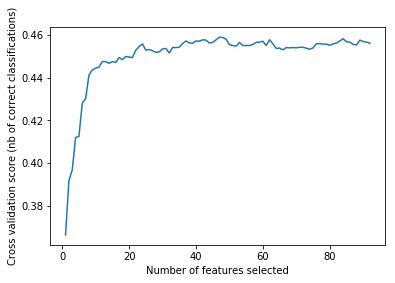

The highest accuracy, 0.4590, is achieved with 46 features.
Ranking of features (`1` indicates selected):
 [40 44 28 38 43 46 14  1  1  9 39 35 25  1 36  1 16  1  1  1  1  1  1  1
  1  1  3  2  1  1 27 34  1  1  1  1  1  1 22 19  1  1  1 33  1  1 32  1
  1  1  1  5  1 41  1 13 26 42 20  1 15  1 21  1  1 10 24 17 23 18  1 12
  1  6  1 45  7  1  4  1 29 31 30  1  1 37 11  1  1  1  1  8]

Estimator:  GaussianNB(priors=None)


RuntimeError: The classifier does not expose "coef_" or "feature_importances_" attributes

In [6]:
# Logistic Regression (from bmiClassify)
from sklearn.linear_model import LogisticRegression
logisticRegression = LogisticRegression(random_state=0)

# # Decision Tree Classifier (from DTCategorical)
# from sklearn.tree import DecisionTreeClassifier
# decisionTree = DecisionTreeClassifier(max_depth = 5)

# K Neighbors Classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')

# Support Vector Machine: linear
from sklearn.svm import SVC
svc_linear = SVC(kernel='linear')

# Support Vector Machine: rbf
from sklearn.svm import SVC
svc_rbf = SVC(kernel='rbf')

# Gaussian Naive Bayes
from sklearn.naive_bayes import GaussianNB
gaussianNB = GaussianNB()

# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy')

# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
randomForestClassifier = RandomForestClassifier(criterion='entropy')

estimators = [logisticRegression,
#               knn,
#               svc_linear,
#               svc_rbf,
              gaussianNB,
              decisionTreeClassifier,
              randomForestClassifier]
outputs = {}
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(3)
scoring = 'accuracy'

for estimator in estimators:
    print('\nEstimator: ', estimator)
    output = get_optimum_features(X_train,
                                  y_train,
                                  estimator, 
                                  cv,
                                  scoring)
    outputs[estimator] = output

In [5]:
estimators

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=5, p=2,
            weights='uniform'),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=False, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 GaussianNB(priors=None),
 DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=No

In [7]:


# from sklearn.model_selection import GridSearchCV
# grid_sr = GridSearchCV(estimator)

TypeError: __init__() missing 1 required positional argument: 'param_grid'


Estimator:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


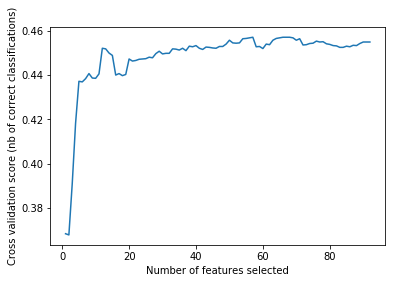

The highest accuracy, 0.4571, is achieved with 65 features.
Ranking of features (`1` indicates selected):
 [20 24  8 18 23 26  1  1  1  1 19 15  5  1 16  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  7 14  1  1  1  1  1  1  2  1  1  1  1 13  1  1 12  1
  1  1  1  1  1 21  1  1  6 22  1  1  1  1  1  1  1  1  4  1  3  1  1  1
  1  1  1 25  1  1  1  1  9 11 10  1  1 17  1  1  1  1  1  1]

Estimator:  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


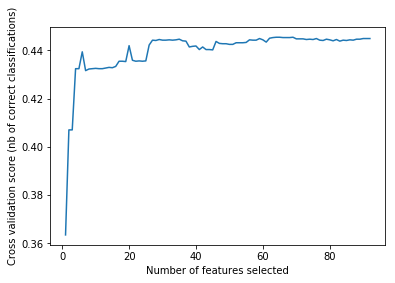

The highest accuracy, 0.4454, is achieved with 63 features.
Ranking of features (`1` indicates selected):
 [22 18 10 13 21  1  1  1  5  6  1  1  1  1  1  8 16  7  2  3  1  1  1  1
  1  1  1  1  1  1  1  1  4  1  1 19 20  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1 23  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  9  1 17 11 12 24 15 14  1  1  1  1  1  1]


In [8]:
# Logistic Regression (from bmiClassify)
from sklearn.linear_model import LogisticRegression
logisticRegression = LogisticRegression(random_state=0)

# # Decision Tree Classifier (from DTCategorical)
# from sklearn.tree import DecisionTreeClassifier
# decisionTree = DecisionTreeClassifier(max_depth = 5)

# # K Neighbors Classifier
# from sklearn.neighbors import KNeighborsClassifier
# knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')

# Support Vector Machine: linear
from sklearn.svm import SVC
svc_linear = SVC(kernel='linear')

# # Support Vector Machine: rbf
# from sklearn.svm import SVC
# svc_rbf = SVC(kernel='rbf')

# # Gaussian Naive Bayes
# from sklearn.naive_bayes import GaussianNB
# gaussianNB = GaussianNB()

# # Decision Tree Classifier
# from sklearn.tree import DecisionTreeClassifier
# decisionTreeClassifier = DecisionTreeClassifier(criterion='entropy')

# # Random Forest Classifier
# from sklearn.ensemble import RandomForestClassifier
# randomForestClassifier = RandomForestClassifier(criterion='entropy')

estimators = [logisticRegression,
#               knn,
#               svc_linear,
              svc_linear]            
# #               svc_rbf,
#               gaussianNB,
#               decisionTreeClassifier,
#               randomForestClassifier]
outputs = {}
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(2)
scoring = 'accuracy'

for estimator in estimators:
    print('\nEstimator: ', estimator)
    output = get_optimum_features(X_train,
                                  y_train,
                                  estimator, 
                                  cv,
                                  scoring)
    outputs[estimator] = output

In [ ]:
from sklearn.model_selection import GridSearchCV
grid_sr = GridSearchCV(estimator)